# Overview of this jupyter notebook

1. Loading the data
2. Hyperparameter optimization for DecisionTree Model
3. Evaluation of the optimized model and saving the results

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 60)
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from skmultilearn.problem_transform import BinaryRelevance
from tqdm.notebook import tqdm_notebook as tq
from warnings import filterwarnings
filterwarnings('ignore')
import pickle
import json
import random

In [3]:
import os
import importlib
from library import etl_helper as etl            # this module contains functions that load, visualize and save the data
from library import faps_color as fapsc        # this module contains the color combination of FAPS Institute
from library import classification_helper as ch  # this module contains helper functions for the classification task
print(importlib.reload(etl))
print(importlib.reload(fapsc))
print(importlib.reload(ch))

<module 'library.etl_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\etl_helper.py'>
<module 'library.faps_color' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\faps_color.py'>
<module 'library.classification_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\classification_helper.py'>


In [4]:
!python -V

Python 3.10.6


# 1. Loading the data

In [5]:
classes = ['0_in_ordnung',
           '1_kleine_durchgangsbohrung',
           '2_versetzte_fuegepartner',
           '3_unebene_fuegeflaeche',
           '4_span_im_gewinde',
           '5_verschmutzte_schraube',
           '6_fremdkoerper_am_gewindeende',
           '7_beschaedigte_schraube']

In [6]:
feature_train = pd.read_pickle("feature_label/mlc_feature_train_tsfresh_2.4.pkl")
feature_train.shape

(1550, 789)

In [7]:
feature_test = pd.read_pickle("feature_label/mlc_feature_test_tsfresh_2.4.pkl")
feature_test.shape

(750, 789)

In [8]:
label_train = pd.read_pickle("feature_label/mlc_label_train_tsfresh_v2.4.pkl")
label_train.shape

(1550, 8)

In [9]:
label_test = pd.read_pickle("feature_label/mlc_label_test_tsfresh_v2.4.pkl")
label_test.shape

(750, 8)

In [10]:
relevance_table = pd.read_pickle("feature_label/mlc_relevance_table_tsfresh_v2.4.pkl")
relevance_table

,feature,type,p_value_0,relevant_0,p_value_1,relevant_1,p_value_2,relevant_2,p_value_3,relevant_3,p_value_4,relevant_4,p_value_5,relevant_5,p_value_6,relevant_6,p_value_7,relevant_7,p_value_8,relevant_8,p_value_9,relevant_9,p_value_10,relevant_10,p_value_11,relevant_11,p_value_12,relevant_12,p_value_13,relevant_13,p_value_14,relevant_14,n_significant,relevant
feature,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
torque__variation_coefficient,torque__variation_coefficient,real,5.197543e-90,True,1.643083e-07,True,5.144671e-13,True,6.022008e-41,True,2.678407e-11,True,3.459922e-02,False,2.137971e-29,True,6.742358e-25,True,5.705008e-03,False,3.158111e-14,True,1.457102e-25,True,1.597761e-07,True,0.029758,False,1.769481e-17,True,0.002942,False,11,True
torque__lempel_ziv_complexity__bins_100,torque__lempel_ziv_complexity__bins_100,real,5.463394e-90,True,9.139738e-09,True,1.787593e-16,True,2.365570e-50,True,2.081732e-21,True,5.843446e-19,True,3.908102e-07,True,4.137441e-09,True,1.990712e-16,True,2.544483e-12,True,4.183211e-17,True,4.656514e-06,True,0.072377,False,1.791119e-30,True,0.000034,True,14,True
torque__mean,torque__mean,real,9.576607e-90,True,2.213726e-06,True,2.304176e-11,True,6.607692e-39,True,3.657118e-13,True,4.674008e-03,False,4.020447e-35,True,1.552304e-34,True,4.396053e-02,False,5.792276e-13,True,9.756297e-24,True,4.440944e-07,True,0.000483,True,7.502963e-16,True,0.000886,True,13,True
"torque__fft_coefficient__attr_""abs""__coeff_0","torque__fft_coefficient__attr_""abs""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
"torque__fft_coefficient__attr_""real""__coeff_0","torque__fft_coefficient__attr_""real""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
torque__friedrich_coefficients__coeff_3__m_3__r_30,torque__friedrich_coefficients__coeff_3__m_3__...,constant,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,0,False
torque__max_langevin_fixed_point__m_3__r_30,torque__max_langevin_fixed_point__m_3__r_30,constant,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,0,False
torque__number_crossing_m__m_-1,torque__number_crossing_m__m_-1,constant,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,0,False


In [11]:
# 615 features are filtered as relevant based on p-value

relevance_table = relevance_table[relevance_table.relevant==True]
relevance_table

,feature,type,p_value_0,relevant_0,p_value_1,relevant_1,p_value_2,relevant_2,p_value_3,relevant_3,p_value_4,relevant_4,p_value_5,relevant_5,p_value_6,relevant_6,p_value_7,relevant_7,p_value_8,relevant_8,p_value_9,relevant_9,p_value_10,relevant_10,p_value_11,relevant_11,p_value_12,relevant_12,p_value_13,relevant_13,p_value_14,relevant_14,n_significant,relevant
feature,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
torque__variation_coefficient,torque__variation_coefficient,real,5.197543e-90,True,1.643083e-07,True,5.144671e-13,True,6.022008e-41,True,2.678407e-11,True,3.459922e-02,False,2.137971e-29,True,6.742358e-25,True,5.705008e-03,False,3.158111e-14,True,1.457102e-25,True,1.597761e-07,True,0.029758,False,1.769481e-17,True,0.002942,False,11,True
torque__lempel_ziv_complexity__bins_100,torque__lempel_ziv_complexity__bins_100,real,5.463394e-90,True,9.139738e-09,True,1.787593e-16,True,2.365570e-50,True,2.081732e-21,True,5.843446e-19,True,3.908102e-07,True,4.137441e-09,True,1.990712e-16,True,2.544483e-12,True,4.183211e-17,True,4.656514e-06,True,0.072377,False,1.791119e-30,True,0.000034,True,14,True
torque__mean,torque__mean,real,9.576607e-90,True,2.213726e-06,True,2.304176e-11,True,6.607692e-39,True,3.657118e-13,True,4.674008e-03,False,4.020447e-35,True,1.552304e-34,True,4.396053e-02,False,5.792276e-13,True,9.756297e-24,True,4.440944e-07,True,0.000483,True,7.502963e-16,True,0.000886,True,13,True
"torque__fft_coefficient__attr_""abs""__coeff_0","torque__fft_coefficient__attr_""abs""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
"torque__fft_coefficient__attr_""real""__coeff_0","torque__fft_coefficient__attr_""real""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"torque__fft_coefficient__attr_""imag""__coeff_92","torque__fft_coefficient__attr_""imag""__coeff_92",real,9.478897e-01,False,1.716470e-01,False,9.849157e-01,False,1.072699e-04,True,8.559883e-01,False,5.015247e-01,False,1.822312e-01,False,4.250886e-01,False,4.911643e-01,False,1.170838e-02,False,1.711853e-01,False,8.991722e-01,False,0.025441,False,7.237413e-01,False,0.292634,False,1,True
"torque__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)",torque__cwt_coefficients__coeff_12__w_2__width...,real,9.544628e-01,False,2.995364e-12,True,1.424985e-01,False,3.158056e-02,False,4.182010e-03,False,5.572269e-01,False,1.291619e-01,False,2.636988e-01,False,2.499537e-07,True,2.074936e-01,False,6.579449e-01,False,8.661737e-02,False,0.083162,False,6.838159e-01,False,0.142855,False,2,True
"torque__fft_coefficient__attr_""real""__coeff_91","torque__fft_coefficient__attr_""real""__coeff_91",real,9.748111e-01,False,1.528592e-01,False,9.135638e-01,False,2.650780e-05,True,9.138683e-01,False,6.113325e-01,False,5.596143e-01,False,2.779372e-01,False,4.141510e-01,False,1.277503e-02,False,1.527884e-01,False,7.170111e-01,False,0.003934,False,5.555035e-01,False,0.163287,False,1,True


In [12]:
relevant_feature = list(relevance_table[relevance_table.relevant==True].feature)
len(relevant_feature)

615

In [13]:
feat_train = feature_train[relevant_feature]
feat_test = feature_test[relevant_feature]
feat_train.shape, feat_test.shape

((1550, 615), (750, 615))

In [14]:
lab_train = label_train.values
lab_test = label_test.values
lab_train.shape, lab_test.shape

((1550, 8), (750, 8))

In [15]:
from sklearn.utils import shuffle

x_train, y_train = shuffle(feat_train, lab_train, random_state=9)
x_test, y_test = shuffle(feat_test, lab_test, random_state=9)

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_test

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

# 2. Hyperparameter optimization for DecisionTree Model

In [17]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [18]:
parameters = [{'classifier': [DecisionTreeClassifier()],
               'classifier__criterion':['gini', 'entropy'], 'classifier__min_samples_leaf': [1,4,8],
               'classifier__min_samples_split':[2,4,8], 'classifier__max_depth':[20,40,80,120,200],
               'classifier__min_impurity_decrease':[0.0, 0.0001, 0.001]}]

search = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='accuracy', verbose=10)
search.fit(x_train, y_train)
print(search.best_score_, search.best_params_)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV 1/5; 1/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 1/5; 1/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.674 total time=   3.3s
[CV 2/5; 1/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 2/5; 1/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.716 total time=   2.9s
[CV 3/5; 1

[CV 4/5; 4/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.684 total time=   2.4s
[CV 5/5; 4/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2
[CV 5/5; 4/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.668 total time=   2.5s
[CV 1/5; 5/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4
[CV 1/5; 5/270] END classifier=DecisionTreeClassifier(), classifier__crite

[CV 2/5; 8/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.735 total time=   2.2s
[CV 3/5; 8/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 3/5; 8/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.742 total time=   2.4s
[CV 4/5; 8/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 4/5; 8/270] END classifier=DecisionTreeClassifier(), classifier__crite

[CV 5/5; 11/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4;, score=0.629 total time=   2.8s
[CV 1/5; 12/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 1/5; 12/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8;, score=0.671 total time=   3.2s
[CV 2/5; 12/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 2/5; 12/270] END classifier=DecisionTreeClassifier(), 

[CV 3/5; 15/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.716 total time=   2.5s
[CV 4/5; 15/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 4/5; 15/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.677 total time=   2.3s
[CV 5/5; 15/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 5/5; 15/270] END classifier=DecisionTreeClassifier(), 

[CV 1/5; 19/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.703 total time=   2.9s
[CV 2/5; 19/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 2/5; 19/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.726 total time=   2.7s
[CV 3/5; 19/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 3/5; 19/270] END classifier=DecisionTreeClassifier(), clas

[CV 4/5; 22/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.697 total time=   1.9s
[CV 5/5; 22/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2
[CV 5/5; 22/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.677 total time=   2.2s
[CV 1/5; 23/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4
[CV 1/5; 23/270] END classifier=DecisionTreeClassifier(), clas

[CV 2/5; 26/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.739 total time=   1.9s
[CV 3/5; 26/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 3/5; 26/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.755 total time=   2.0s
[CV 4/5; 26/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=20, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 4/5; 26/270] END classifier=DecisionTreeClassifier(), clas

[CV 5/5; 29/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4;, score=0.658 total time=   2.8s
[CV 1/5; 30/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 1/5; 30/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8;, score=0.671 total time=   3.3s
[CV 2/5; 30/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 2/5; 30/270] END classifier=DecisionTreeClassifier(), classifier__

[CV 3/5; 33/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.729 total time=   2.5s
[CV 4/5; 33/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 4/5; 33/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.668 total time=   2.3s
[CV 5/5; 33/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 5/5; 33/270] END classifier=DecisionTreeClassifier(), classifier__

[CV 1/5; 37/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.684 total time=   3.2s
[CV 2/5; 37/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 2/5; 37/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.732 total time=   2.9s
[CV 3/5; 37/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 3/5; 37/270] END classifier=DecisionTreeClassifier(), 

[CV 4/5; 40/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.674 total time=   2.3s
[CV 5/5; 40/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2
[CV 5/5; 40/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.652 total time=   2.5s
[CV 1/5; 41/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4
[CV 1/5; 41/270] END classifier=DecisionTreeClassifier(), 

[CV 2/5; 44/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.742 total time=   2.2s
[CV 3/5; 44/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 3/5; 44/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.755 total time=   2.3s
[CV 4/5; 44/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 4/5; 44/270] END classifier=DecisionTreeClassifier(), 

[CV 5/5; 47/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4;, score=0.655 total time=   2.6s
[CV 1/5; 48/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 1/5; 48/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8;, score=0.658 total time=   2.9s
[CV 2/5; 48/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 2/5; 48/270] END classifier=DecisionTreeClassifier(), clas

[CV 3/5; 51/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.732 total time=   2.2s
[CV 4/5; 51/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 4/5; 51/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.690 total time=   2.0s
[CV 5/5; 51/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=40, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 5/5; 51/270] END classifier=DecisionTreeClassifier(), clas

[CV 1/5; 55/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.681 total time=   3.3s
[CV 2/5; 55/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 2/5; 55/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.703 total time=   3.0s
[CV 3/5; 55/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 3/5; 55/270] END classifier=DecisionTreeClassifier(), classifier__

[CV 4/5; 58/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.674 total time=   2.3s
[CV 5/5; 58/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2
[CV 5/5; 58/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.658 total time=   2.5s
[CV 1/5; 59/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4
[CV 1/5; 59/270] END classifier=DecisionTreeClassifier(), classifier__

[CV 2/5; 62/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.758 total time=   2.2s
[CV 3/5; 62/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 3/5; 62/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.752 total time=   2.4s
[CV 4/5; 62/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 4/5; 62/270] END classifier=DecisionTreeClassifier(), classifier__

[CV 5/5; 65/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4;, score=0.623 total time=   2.8s
[CV 1/5; 66/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 1/5; 66/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8;, score=0.665 total time=   3.2s
[CV 2/5; 66/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 2/5; 66/270] END classifier=DecisionTreeClassifier(), 

[CV 3/5; 69/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.729 total time=   2.6s
[CV 4/5; 69/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 4/5; 69/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.677 total time=   2.3s
[CV 5/5; 69/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 5/5; 69/270] END classifier=DecisionTreeClassifier(), 

[CV 1/5; 73/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.687 total time=   2.9s
[CV 2/5; 73/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 2/5; 73/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.719 total time=   2.7s
[CV 3/5; 73/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 3/5; 73/270] END classifier=DecisionTreeClassifier(), clas

[CV 4/5; 76/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.700 total time=   2.0s
[CV 5/5; 76/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2
[CV 5/5; 76/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.668 total time=   2.2s
[CV 1/5; 77/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4
[CV 1/5; 77/270] END classifier=DecisionTreeClassifier(), clas

[CV 2/5; 80/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.755 total time=   1.9s
[CV 3/5; 80/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 3/5; 80/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.758 total time=   2.0s
[CV 4/5; 80/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=80, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 4/5; 80/270] END classifier=DecisionTreeClassifier(), clas

[CV 5/5; 83/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4;, score=0.648 total time=   2.7s
[CV 1/5; 84/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 1/5; 84/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8;, score=0.681 total time=   3.3s
[CV 2/5; 84/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 2/5; 84/270] END classifier=DecisionTreeClassifier(), classifi

[CV 3/5; 87/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.732 total time=   2.5s
[CV 4/5; 87/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 4/5; 87/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.690 total time=   2.2s
[CV 5/5; 87/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 5/5; 87/270] END classifier=DecisionTreeClassifier(), classifi

[CV 1/5; 91/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.655 total time=   3.4s
[CV 2/5; 91/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 2/5; 91/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.732 total time=   2.9s
[CV 3/5; 91/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 3/5; 91/270] END classifier=DecisionTreeClassifier

[CV 4/5; 94/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.674 total time=   2.4s
[CV 5/5; 94/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2
[CV 5/5; 94/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.658 total time=   2.5s
[CV 1/5; 95/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4
[CV 1/5; 95/270] END classifier=DecisionTreeClassifier

[CV 2/5; 98/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.752 total time=   2.3s
[CV 3/5; 98/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 3/5; 98/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.761 total time=   2.4s
[CV 4/5; 98/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 4/5; 98/270] END classifier=DecisionTreeClassifier

[CV 5/5; 101/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4;, score=0.658 total time=   2.6s
[CV 1/5; 102/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 1/5; 102/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8;, score=0.665 total time=   2.9s
[CV 2/5; 102/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 2/5; 102/270] END classifier=DecisionTreeClassifie

[CV 3/5; 105/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.703 total time=   2.2s
[CV 4/5; 105/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 4/5; 105/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.694 total time=   1.9s
[CV 5/5; 105/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=120, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 5/5; 105/270] END classifier=DecisionTreeClassifie

[CV 1/5; 109/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.652 total time=   3.3s
[CV 2/5; 109/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 2/5; 109/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.719 total time=   2.8s
[CV 3/5; 109/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 3/5; 109/270] END classifier=DecisionTreeClassifier(), cla

[CV 4/5; 112/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.665 total time=   2.2s
[CV 5/5; 112/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2
[CV 5/5; 112/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.661 total time=   2.5s
[CV 1/5; 113/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4
[CV 1/5; 113/270] END classifier=DecisionTreeClassifier(), cla

[CV 2/5; 116/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.745 total time=   2.2s
[CV 3/5; 116/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 3/5; 116/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.752 total time=   2.3s
[CV 4/5; 116/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 4/5; 116/270] END classifier=DecisionTreeClassifier(), cla

[CV 5/5; 119/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4;, score=0.642 total time=   2.7s
[CV 1/5; 120/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 1/5; 120/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8;, score=0.681 total time=   3.3s
[CV 2/5; 120/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 2/5; 120/270] END classifier=DecisionTreeClass

[CV 3/5; 123/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.735 total time=   2.6s
[CV 4/5; 123/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 4/5; 123/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.690 total time=   2.3s
[CV 5/5; 123/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 5/5; 123/270] END classifier=DecisionTreeClass

[CV 1/5; 127/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.681 total time=   3.0s
[CV 2/5; 127/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 2/5; 127/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.732 total time=   2.7s
[CV 3/5; 127/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 3/5; 127/270] END classifier=DecisionTreeClassifie

[CV 4/5; 130/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.677 total time=   2.0s
[CV 5/5; 130/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2
[CV 5/5; 130/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.665 total time=   2.1s
[CV 1/5; 131/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4
[CV 1/5; 131/270] END classifier=DecisionTreeClassifie

[CV 2/5; 134/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.755 total time=   1.9s
[CV 3/5; 134/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 3/5; 134/270] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.758 total time=   2.0s
[CV 4/5; 134/270] START classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=200, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 4/5; 134/270] END classifier=DecisionTreeClassifie

[CV 5/5; 137/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4;, score=0.716 total time=   2.6s
[CV 1/5; 138/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 1/5; 138/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8;, score=0.690 total time=   2.6s
[CV 2/5; 138/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 2/5; 138/270] END classifier=DecisionTreeClassifie

[CV 3/5; 141/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.748 total time=   2.7s
[CV 4/5; 141/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 4/5; 141/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.742 total time=   2.4s
[CV 5/5; 141/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 5/5; 141/270] END classifier=DecisionTreeClassifie

[CV 1/5; 145/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.700 total time=   2.6s
[CV 2/5; 145/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 2/5; 145/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.761 total time=   2.5s
[CV 3/5; 145/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 3/5; 145/270] END classifier=DecisionT

[CV 4/5; 148/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.726 total time=   2.6s
[CV 5/5; 148/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2
[CV 5/5; 148/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.716 total time=   2.6s
[CV 1/5; 149/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4
[CV 1/5; 149/270] END classifier=DecisionT

[CV 2/5; 152/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.742 total time=   2.4s
[CV 3/5; 152/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 3/5; 152/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.723 total time=   2.6s
[CV 4/5; 152/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 4/5; 152/270] END classifier=DecisionT

[CV 5/5; 155/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4;, score=0.703 total time=   2.7s
[CV 1/5; 156/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 1/5; 156/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8;, score=0.694 total time=   2.6s
[CV 2/5; 156/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 2/5; 156/270] END classifier=DecisionTreeC

[CV 3/5; 159/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.752 total time=   2.6s
[CV 4/5; 159/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 4/5; 159/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.735 total time=   2.5s
[CV 5/5; 159/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=20, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 5/5; 159/270] END classifier=DecisionTreeC

[CV 1/5; 163/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.677 total time=   2.6s
[CV 2/5; 163/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 2/5; 163/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.735 total time=   2.5s
[CV 3/5; 163/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 3/5; 163/270] END classifier=DecisionTreeClassifie

[CV 4/5; 166/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.739 total time=   2.5s
[CV 5/5; 166/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2
[CV 5/5; 166/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.713 total time=   2.6s
[CV 1/5; 167/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4
[CV 1/5; 167/270] END classifier=DecisionTreeClassifie

[CV 2/5; 170/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.745 total time=   2.4s
[CV 3/5; 170/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 3/5; 170/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.723 total time=   2.6s
[CV 4/5; 170/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 4/5; 170/270] END classifier=DecisionTreeClassifie

[CV 5/5; 173/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4;, score=0.723 total time=   2.6s
[CV 1/5; 174/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 1/5; 174/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8;, score=0.690 total time=   2.6s
[CV 2/5; 174/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 2/5; 174/270] END classifier=DecisionT

[CV 3/5; 177/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.745 total time=   2.7s
[CV 4/5; 177/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 4/5; 177/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.745 total time=   2.5s
[CV 5/5; 177/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 5/5; 177/270] END classifier=DecisionT

[CV 1/5; 181/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.687 total time=   2.6s
[CV 2/5; 181/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 2/5; 181/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.755 total time=   2.5s
[CV 3/5; 181/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 3/5; 181/270] END classifier=DecisionTreeC

[CV 4/5; 184/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.735 total time=   2.5s
[CV 5/5; 184/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2
[CV 5/5; 184/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.729 total time=   2.6s
[CV 1/5; 185/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4
[CV 1/5; 185/270] END classifier=DecisionTreeC

[CV 2/5; 188/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.732 total time=   2.4s
[CV 3/5; 188/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 3/5; 188/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.726 total time=   2.5s
[CV 4/5; 188/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=40, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 4/5; 188/270] END classifier=DecisionTreeC

[CV 5/5; 191/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4;, score=0.703 total time=   2.7s
[CV 1/5; 192/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 1/5; 192/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8;, score=0.687 total time=   2.7s
[CV 2/5; 192/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 2/5; 192/270] END classifier=DecisionTreeClassifie

[CV 3/5; 195/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.758 total time=   2.6s
[CV 4/5; 195/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 4/5; 195/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.732 total time=   2.5s
[CV 5/5; 195/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 5/5; 195/270] END classifier=DecisionTreeClassifie

[CV 1/5; 199/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.681 total time=   2.6s
[CV 2/5; 199/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 2/5; 199/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.748 total time=   2.6s
[CV 3/5; 199/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 3/5; 199/270] END classifier=DecisionT

[CV 4/5; 202/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.735 total time=   2.4s
[CV 5/5; 202/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2
[CV 5/5; 202/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.729 total time=   2.6s
[CV 1/5; 203/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4
[CV 1/5; 203/270] END classifier=DecisionT

[CV 2/5; 206/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.755 total time=   2.3s
[CV 3/5; 206/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 3/5; 206/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.726 total time=   2.5s
[CV 4/5; 206/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 4/5; 206/270] END classifier=DecisionT

[CV 5/5; 209/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4;, score=0.694 total time=   2.6s
[CV 1/5; 210/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 1/5; 210/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8;, score=0.697 total time=   2.6s
[CV 2/5; 210/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 2/5; 210/270] END classifier=DecisionTreeC

[CV 3/5; 213/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.748 total time=   2.7s
[CV 4/5; 213/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 4/5; 213/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.723 total time=   2.5s
[CV 5/5; 213/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=80, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 5/5; 213/270] END classifier=DecisionTreeC

[CV 1/5; 217/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.690 total time=   2.6s
[CV 2/5; 217/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 2/5; 217/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.748 total time=   2.6s
[CV 3/5; 217/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 3/5; 217/270] END classifier=DecisionTreeClass

[CV 4/5; 220/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.735 total time=   2.6s
[CV 5/5; 220/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2
[CV 5/5; 220/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.713 total time=   2.5s
[CV 1/5; 221/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4
[CV 1/5; 221/270] END classifier=DecisionTreeClass

[CV 2/5; 224/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.745 total time=   2.3s
[CV 3/5; 224/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 3/5; 224/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.723 total time=   2.6s
[CV 4/5; 224/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 4/5; 224/270] END classifier=DecisionTreeClass

[CV 5/5; 227/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4;, score=0.710 total time=   2.6s
[CV 1/5; 228/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 1/5; 228/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8;, score=0.697 total time=   2.6s
[CV 2/5; 228/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 2/5; 228/270] END classifier=Decis

[CV 3/5; 231/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.752 total time=   2.6s
[CV 4/5; 231/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 4/5; 231/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.742 total time=   2.4s
[CV 5/5; 231/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 5/5; 231/270] END classifier=Decis

[CV 1/5; 235/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.697 total time=   2.6s
[CV 2/5; 235/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 2/5; 235/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.729 total time=   2.6s
[CV 3/5; 235/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 3/5; 235/270] END classifier=DecisionT

[CV 4/5; 238/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.732 total time=   2.5s
[CV 5/5; 238/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2
[CV 5/5; 238/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.713 total time=   2.6s
[CV 1/5; 239/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4
[CV 1/5; 239/270] END classifier=DecisionT

[CV 2/5; 242/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.745 total time=   2.4s
[CV 3/5; 242/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 3/5; 242/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.713 total time=   2.6s
[CV 4/5; 242/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=120, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 4/5; 242/270] END classifier=DecisionT

[CV 5/5; 245/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4;, score=0.710 total time=   2.6s
[CV 1/5; 246/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 1/5; 246/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8;, score=0.677 total time=   2.6s
[CV 2/5; 246/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 2/5; 246/270] END classifier=DecisionTreeClass

[CV 3/5; 249/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.761 total time=   2.6s
[CV 4/5; 249/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 4/5; 249/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.729 total time=   2.5s
[CV 5/5; 249/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 5/5; 249/270] END classifier=DecisionTreeClass

[CV 1/5; 253/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.700 total time=   2.6s
[CV 2/5; 253/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 2/5; 253/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.752 total time=   2.6s
[CV 3/5; 253/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2
[CV 3/5; 253/270] END classifier=Decis

[CV 4/5; 256/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.729 total time=   2.5s
[CV 5/5; 256/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2
[CV 5/5; 256/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.726 total time=   2.6s
[CV 1/5; 257/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4
[CV 1/5; 257/270] END classifier=Decis

[CV 2/5; 260/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.735 total time=   2.4s
[CV 3/5; 260/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 3/5; 260/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4;, score=0.726 total time=   2.6s
[CV 4/5; 260/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4
[CV 4/5; 260/270] END classifier=Decis

[CV 5/5; 263/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4;, score=0.681 total time=   2.6s
[CV 1/5; 264/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 1/5; 264/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8;, score=0.706 total time=   2.7s
[CV 2/5; 264/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8
[CV 2/5; 264/270] END classifier=DecisionT

[CV 3/5; 267/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.745 total time=   2.7s
[CV 4/5; 267/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 4/5; 267/270] END classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8;, score=0.713 total time=   2.5s
[CV 5/5; 267/270] START classifier=DecisionTreeClassifier(), classifier__criterion=entropy, classifier__max_depth=200, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8
[CV 5/5; 267/270] END classifier=DecisionT

0.7387096774193548 {'classifier': DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=4,
                       min_samples_split=4), 'classifier__criterion': 'entropy', 'classifier__max_depth': 20, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 4}


In [19]:
results = pd.DataFrame(search.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__criterion,param_classifier__max_depth,param_classifier__min_impurity_decrease,param_classifier__min_samples_leaf,param_classifier__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.048234,0.163836,0.057088,0.013020,"DecisionTreeClassifier(criterion='entropy', ma...",gini,20,0.0,1,2,{'classifier': DecisionTreeClassifier(criterio...,0.674194,0.716129,0.748387,0.703226,0.622581,0.692903,0.042473,255
1,3.053097,0.170735,0.053067,0.007672,"DecisionTreeClassifier(criterion='entropy', ma...",gini,20,0.0,1,4,{'classifier': DecisionTreeClassifier(criterio...,0.667742,0.696774,0.758065,0.696774,0.638710,0.691613,0.039592,259
2,3.090772,0.150007,0.056295,0.012284,"DecisionTreeClassifier(criterion='entropy', ma...",gini,20,0.0,1,8,{'classifier': DecisionTreeClassifier(criterio...,0.683871,0.709677,0.761290,0.706452,0.651613,0.702581,0.035944,210
3,2.561278,0.082151,0.049840,0.008249,"DecisionTreeClassifier(criterion='entropy', ma...",gini,20,0.0,4,2,{'classifier': DecisionTreeClassifier(criterio...,0.696774,0.722581,0.732258,0.683871,0.667742,0.700645,0.023915,223
4,2.571888,0.105905,0.047862,0.008384,"DecisionTreeClassifier(criterion='entropy', ma...",gini,20,0.0,4,4,{'classifier': DecisionTreeClassifier(criterio...,0.661290,0.741935,0.735484,0.664516,0.661290,0.692903,0.037475,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,2.649826,0.060144,0.057626,0.011913,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,200,0.001,4,4,{'classifier': DecisionTreeClassifier(criterio...,0.680645,0.751613,0.748387,0.732258,0.729032,0.728387,0.025433,60
266,2.627445,0.053345,0.054222,0.006927,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,200,0.001,4,8,{'classifier': DecisionTreeClassifier(criterio...,0.683871,0.745161,0.745161,0.712903,0.732258,0.723871,0.023226,109
267,2.493181,0.101525,0.046873,0.000012,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,200,0.001,8,2,{'classifier': DecisionTreeClassifier(criterio...,0.700000,0.735484,0.709677,0.751613,0.712903,0.721935,0.018854,119
268,2.545886,0.088046,0.053131,0.007656,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,200,0.001,8,4,{'classifier': DecisionTreeClassifier(criterio...,0.687097,0.741935,0.719355,0.748387,0.716129,0.722581,0.021687,115


In [35]:
results.sort_values(by=["rank_test_score"]).iloc[:40]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__criterion,param_classifier__max_depth,param_classifier__min_impurity_decrease,param_classifier__min_samples_leaf,param_classifier__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
167,2.646908,0.109692,0.053338,0.007489,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,40,0.0,4,8,{'classifier': DecisionTreeClassifier(criterio...,0.703226,0.751613,0.764516,0.741935,0.732258,0.738710,0.020706,1
139,2.575577,0.051971,0.053121,0.007654,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,20,0.0,4,4,{'classifier': DecisionTreeClassifier(criterio...,0.703226,0.764516,0.754839,0.745161,0.725806,0.738710,0.021878,1
156,2.638236,0.081627,0.056635,0.007645,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,20,0.001,4,2,{'classifier': DecisionTreeClassifier(criterio...,0.687097,0.770968,0.761290,0.735484,0.738710,0.738710,0.029068,1
141,2.491900,0.074200,0.050002,0.006239,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,20,0.0,8,2,{'classifier': DecisionTreeClassifier(criterio...,0.712903,0.748387,0.729032,0.770968,0.729032,0.738065,0.019927,4
264,2.635818,0.073299,0.047322,0.004132,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,200,0.001,4,2,{'classifier': DecisionTreeClassifier(criterio...,0.703226,0.758065,0.758065,0.738710,0.722581,0.736129,0.021143,5
248,2.601417,0.064467,0.060724,0.012097,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,200,0.0,4,8,{'classifier': DecisionTreeClassifier(criterio...,0.709677,0.758065,0.761290,0.729032,0.716129,0.734839,0.021241,6
263,2.689134,0.106811,0.056357,0.007740,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,200,0.001,1,8,{'classifier': DecisionTreeClassifier(criterio...,0.706452,0.745161,0.761290,0.745161,0.716129,0.734839,0.020340,6
183,2.605124,0.069417,0.056253,0.007659,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,40,0.001,4,2,{'classifier': DecisionTreeClassifier(criterio...,0.696774,0.764516,0.748387,0.735484,0.729032,0.734839,0.022571,6
240,2.493767,0.081853,0.059372,0.006250,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,120,0.001,8,2,{'classifier': DecisionTreeClassifier(criterio...,0.700000,0.754839,0.725806,0.761290,0.729032,0.734194,0.022030,9
194,2.607417,0.045673,0.056244,0.007659,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,80,0.0,4,8,{'classifier': DecisionTreeClassifier(criterio...,0.700000,0.761290,0.758065,0.732258,0.719355,0.734194,0.023226,9


In [22]:
best_clf = search.best_estimator_
best_clf

BinaryRelevance(classifier=DecisionTreeClassifier(criterion='entropy',
                                                  max_depth=20,
                                                  min_samples_leaf=4,
                                                  min_samples_split=4),
                require_dense=[True, True])

In [36]:
search.best_params_

{'classifier': DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=4,
                        min_samples_split=4),
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 20,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 4,
 'classifier__min_samples_split': 4}

# 3. Evaluation of the optimized model and saving the results

In [56]:
#with open('model/mlc_ml_br_decisiontree_v2.4.pkl', 'wb') as f:
#    pickle.dump(best_clf, f)

In [16]:
with open('model/mlc_ml_br_decisiontree_v2.4.pkl', 'rb') as f:
    best_clf = pickle.load(f)

In [17]:
best_clf

BinaryRelevance(classifier=DecisionTreeClassifier(criterion='entropy',
                                                  max_depth=20,
                                                  min_samples_leaf=4,
                                                  min_samples_split=4),
                require_dense=[True, True])

In [18]:
y_pred = best_clf.predict(x_test)
y_pred = y_pred.toarray()
y_pred

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 1]], dtype=int32)

In [19]:
acc, ham = ch.mlc_result(y_test, y_pred)



acc: 0.6973333333333334
hamming loss: 0.04783333333333333

              precision    recall  f1-score   support

           0      0.980     0.980     0.980        50
           1      0.957     0.890     0.922       100
           2      0.841     0.795     0.817       200
           3      0.979     0.935     0.957       200
           4      0.606     0.600     0.603       100
           5      0.915     0.787     0.846       150
           6      0.980     0.967     0.973       150
           7      0.946     0.840     0.890       250

   micro avg      0.907     0.848     0.876      1200
   macro avg      0.900     0.849     0.874      1200
weighted avg      0.908     0.848     0.876      1200
 samples avg      0.884     0.866     0.861      1200



In [20]:
dfzip = ch.convert_and_zip_label(y_test, y_pred)
ch.cm_multi(dfzip)

Pred,0,1,2,3,4,5,6,7,03,12,15,16,24,25,26,27,34,35,37,46,47,56,57,67,126,156,237,246,247,256,267,345,347,357,457,467,2467,3457,23567,noclass,Total
True,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,50
1,0,44,0,0,1,0,0,0,0,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
2,0,2,31,0,1,0,0,0,0,1,0,0,8,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,50
3,0,0,0,45,0,0,0,0,1,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,50
4,0,0,4,0,24,0,0,2,0,0,0,0,5,0,0,1,1,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,8,50
5,0,0,0,1,0,42,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,50
6,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
7,0,0,1,0,1,0,0,37,0,0,0,0,0,0,0,1,0,0,1,0,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,50
16,0,1,0,0,0,0,3,0,0,0,0,33,0,0,5,0,0,0,0,2,0,0,0,0,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50


In [21]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(y_test, y_pred)

array([[[699,   1],
        [  1,  49]],

       [[646,   4],
        [ 11,  89]],

       [[520,  30],
        [ 41, 159]],

       [[546,   4],
        [ 13, 187]],

       [[611,  39],
        [ 40,  60]],

       [[589,  11],
        [ 32, 118]],

       [[597,   3],
        [  5, 145]],

       [[488,  12],
        [ 40, 210]]], dtype=int64)

In [22]:
y_test0 = ch.swap_zero_one(y_test, 0)
y_test0

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [23]:
y_pred0 = ch.swap_zero_one(y_pred, 0)
y_pred0

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

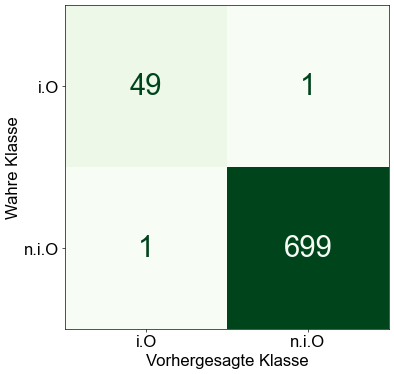

In [25]:
ch.plot_calc_cm(y_test0, y_pred0, class_name=["i.O", "n.i.O"], dpi=60)

In [49]:
search.best_params_

{'classifier': DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=4,
                        min_samples_split=4),
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 20,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 4,
 'classifier__min_samples_split': 4}

In [50]:
best_param = {'classifier__criterion': 'entropy',
              'classifier__max_depth': 20,
              'classifier__min_impurity_decrease': 0.0,
              'classifier__min_samples_leaf': 1,
              'classifier__min_samples_split': 2}

In [51]:
def collect_results(clf, y_true, y_pred, algorithm, params, best_param):
    
    res = {"algorithm":algorithm, "params":params, "best_param":best_param,
           "rec_0":None, "pre_0":None, "f1_0":None, "rec_weighted":None, "pre_weighted":None, "f1_weighted":None, "acc":None}
    
    y_true0 = ch.swap_zero_one(y_true, 0)
    y_pred0 = ch.swap_zero_one(y_pred, 0)
    
    res["rec_0"] = recall_score(y_true0, y_pred0)
    res["pre_0"] = precision_score(y_true0, y_pred0)
    res["f1_0"] = f1_score(y_true0, y_pred0)
    res["rec_weighted"]= recall_score(y_true, y_pred, average='weighted')
    res["f1_weighted"]= f1_score(y_true, y_pred, average='weighted')
    res["pre_weighted"]= precision_score(y_true, y_pred, average='weighted')
    res["acc"] = accuracy_score(y_true, y_pred)
    
    for val in res.keys():
        if res[val]==None:
            print("somethong is wrong")
    
    return res

In [52]:
parameters[0].pop("classifier")
parameters

[{'classifier__criterion': ['gini', 'entropy'],
  'classifier__min_samples_leaf': [1, 4, 8],
  'classifier__min_samples_split': [2, 4, 8],
  'classifier__max_depth': [20, 40, 80, 120, 200],
  'classifier__min_impurity_decrease': [0.0, 0.0001, 0.001]}]

In [53]:
res = collect_results(best_clf, y_test, y_pred, algorithm="decisiontree", params=parameters, best_param=best_param)
res

{'algorithm': 'decisiontree',
 'params': [{'classifier__criterion': ['gini', 'entropy'],
   'classifier__min_samples_leaf': [1, 4, 8],
   'classifier__min_samples_split': [2, 4, 8],
   'classifier__max_depth': [20, 40, 80, 120, 200],
   'classifier__min_impurity_decrease': [0.0, 0.0001, 0.001]}],
 'best_param': {'classifier__criterion': 'entropy',
  'classifier__max_depth': 20,
  'classifier__min_impurity_decrease': 0.0,
  'classifier__min_samples_leaf': 1,
  'classifier__min_samples_split': 2},
 'rec_0': 0.9985714285714286,
 'pre_0': 0.9985714285714286,
 'f1_0': 0.9985714285714286,
 'rec_weighted': 0.8475,
 'pre_weighted': 0.9083547668227885,
 'f1_weighted': 0.8763687337570195,
 'acc': 0.6973333333333334}

In [54]:
filename = "mlc_ml_br_hyperopt_results_v2.4.json"
key_algorithm = "dt"
hyperopt_result = res

In [55]:
if os.path.exists(f"results/{filename}") == False:
    with open(f"results/{filename}", "w") as f:
        json.dump({f"{key_algorithm}":hyperopt_result}, f)
        f.close()
else:
    with open(f"results/{filename}", "r") as f:
        data = json.load(f)
        data.update({f"{key_algorithm}":hyperopt_result})
        
    with open(f"results/{filename}", "w") as f:
        json.dump(data, f)
        f.close()